<B><H2> MELBOURNE HOUSE PRICE ESTIMATOR </H2></B><H5>TENSORFLOW REGRESSION SEQUENTIAL DNN MODEL</H5>


In [1]:
import docker
import requests
import json
import numpy as np
import pandas as pd



#TENSORFLOW API
import tensorflow as tf
import tensorflow_data_validation as tfdv
# Feature Engineering
from tensorflow import feature_column as fc
from keras.models import Sequential
from keras import layers
from keras import utils
# TF Dataset for input pipeline
import tensorflow_datasets as tfds

# VISUALISATION API
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn is a Python data visualization library based on matplotlib.

# Import train_test_split function from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Used to calculate stats such as Z score, standard deviation etc.
from scipy import stats


2022-07-29 03:47:28.088371: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-29 03:47:28.240276: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-29 03:47:28.240343: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<H5> READ THE DATA INTO PANDAS DATAFRAME.</H5> Remove any NULL values

In [ ]:
# Import data from CSV into pandas DF
df= pd.read_csv('data/Melbourne/Melbourne_area.csv')
# Check if there any NULL or NaN values
df.isnull().sum()
# Drop any NA values
df = df.dropna(how='any',axis=0)
# Check that there is no longer Null values
df.isnull().sum()
# Look at DF to get a feel of data
df.head(2)


In [ ]:
df.info()

<h5> 1. Define Numeric, Categorical & Features that need to be dropped
<h5> 2. Performing ONE HOT ENCODING on CATEGORICAL features
<h5> 3. Drop unwanted features </h5>




In [ ]:
# Above there is a combination of categorical & numerical features with 'Price' being the label. We will need to classify the 
# features into the following:
drop_cat = False

num_feat = ['Bedrooms','Bathrooms','Cars','Area','Latitude','Longitude','Distance']
cat_feat = ['Suburb','Type','Method']
drop_feat = ['Street','Address','State','Postcode','Date','Agent']

# Drop features that are not required
if set(drop_feat).issubset(df.columns):
  df = df.drop(drop_feat, axis = 1)
  if drop_cat:
    if set(cat_feat).issubset(df.columns):
      df = df.drop(cat_feat, axis = 1)
  else:
     for feat in cat_feat:
       dummy = pd.get_dummies(df[feat], prefix=feat)
       df = pd.merge(left=df,right=dummy,left_index=True,right_index=True,)
     df = df.drop(cat_feat, axis = 1)



df.head()

<H4> EXPLORATORY DATA ANALYSIS (EDA) </H4>

Explore Relationships between Numerical Features & Price (label)

In [ ]:
sns.pairplot(data = df, y_vars= ['Price'], x_vars = num_feat)

Using Pandas statistics to look for Outliers

Filter out Outliers using either Z Score Method (normal discribution) or IQR method.

In [ ]:
method = 'Zscore'
# Interquartile range (IQR) method should be used for NON normal distribution

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

if method == 'Zscore':
  df = df[(np.abs(stats.zscore(df[num_feat])) < 3).all(axis=1)]
else:
  remove_outlier(df, num_feat)


Confirm that Outliers have been removed

In [ ]:
df.describe()

In [ ]:
sns.pairplot(data = df,y_vars=['Price'],x_vars=num_feat)

<H4> Plot of Lattitude & longitude showing pricing in each location</H4>
Observe that suburbs closer to the city centre generally are more expensive

In [ ]:
plt.scatter(x = df['Longitude'], y = df['Latitude'],c =df['Price'],alpha=0.8,s=df['Price']/50000,cmap='nipy_spectral' )

Data Splitting into TRAIN,VALIDATION & TEST DF using Scikit Learn function

In [ ]:
# Let's split the dataset into train, validation, and test sets as Pandas DF format
train, test = train_test_split(df, test_size=0.2,random_state=42)
train, val = train_test_split(train, test_size=0.2,random_state=42)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

Defining a normalization/scaling function to be used for numerical features

In [ ]:
def normalize(df):
    result = df.copy()
    for feature_name in num_feat:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

Normalizing the Training Data,Valuation & test Numerical Features

In [ ]:
X_train = normalize(train.drop(['Price'], axis =1))
Y_train = train['Price']

X_test = normalize(test.drop(['Price'], axis =1))
Y_test = test['Price']

X_val = normalize(val.drop(['Price'], axis =1))
Y_val = val['Price']


<h3> Defining & Training a Tensorflow Sequential Regression DNN model.</h3>

In [10]:
# Model create

# `tf.keras.Sequential()` groups a linear stack of layers into a tf.keras.Model.
model = tf.keras.Sequential([
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='linear',  name='Price')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=60)



1155/1155 [==============================] - 12s 10ms/step - loss: 151630757888.0000 - mse: 151630757888.0000 - val_loss: 164961697792.0000 - val_mse: 164961697792.0000
Epoch 50/60
1155/1155 [==============================] - 11s 10ms/step - loss: 151409524736.0000 - mse: 151409524736.0000 - val_loss: 165998215168.0000 - val_mse: 165998215168.0000
Epoch 51/60
1155/1155 [==============================] - 17s 15ms/step - loss: 151225827328.0000 - mse: 151225827328.0000 - val_loss: 164633837568.0000 - val_mse: 164633837568.0000
Epoch 52/60
1155/1155 [==============================] - 14s 12ms/step - loss: 151045767168.0000 - mse: 151045767168.0000 - val_loss: 166218383360.0000 - val_mse: 166218383360.0000
Epoch 53/60
1155/1155 [==============================] - 13s 11ms/step - loss: 151006117888.0000 - mse: 151006117888.0000 - val_loss: 166691667968.0000 - val_mse: 166691667968.0000
Epoch 54/60
1155/1155 [==============================] - 13s 12ms/step - loss: 150736584704.0000 - mse: 150

<h4> Evaluating trained model performance using EVALUATION data </h4>

In [11]:
loss, mse = model.evaluate(X_val,Y_val)
print("Mean Squared Error", mse)
print("Root MEAN SQUARE ERROR $",np.sqrt(mse))

289/289 [==============================] - 2s 6ms/step - loss: 166862372864.0000 - mse: 166862372864.0000
Mean Squared Error 166862372864.0
Root MEAN SQUARE ERROR $ 408487.9103033528


<h4> PLOTTING OF LOSS/MSE for TRAINING & EVALUATION DATA  </h4>
Useful to determine underfitting/overfitting as well as optimal number of epcochs for training

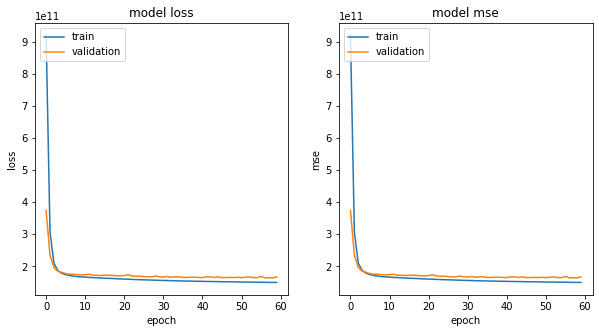

In [12]:
# Use matplotlib to draw the model's loss curves for training and validation
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');

# Plotting
plot_curves(history, ['loss', 'mse'])

<H3> PREDICTION </H3>
<h4>Using TEST data to make PRICE prediction & compare ACTUAL vs PREDICTED</h4>
 

361/361 [==============================] - 3s 5ms/step
PREDICTION: $1845345.25   ACTUAL: 1320000 DIFFERENCE: $525.34525
PREDICTION: $890755.1875   ACTUAL: 896000 DIFFERENCE: $-5.2448125
PREDICTION: $403788.375   ACTUAL: 500000 DIFFERENCE: $-96.211625
PREDICTION: $1098593.0   ACTUAL: 1300000 DIFFERENCE: $-201.407
PREDICTION: $1578838.375   ACTUAL: 1550000 DIFFERENCE: $28.838375
PREDICTION: $1103746.875   ACTUAL: 1263000 DIFFERENCE: $-159.253125
PREDICTION: $2505583.75   ACTUAL: 1950000 DIFFERENCE: $555.58375
PREDICTION: $1327804.75   ACTUAL: 1135000 DIFFERENCE: $192.80475
PREDICTION: $2250281.75   ACTUAL: 1947500 DIFFERENCE: $302.78175
PREDICTION: $2475424.0   ACTUAL: 2515000 DIFFERENCE: $-39.576
PREDICTION: $619387.125   ACTUAL: 615000 DIFFERENCE: $4.387125
PREDICTION: $966932.125   ACTUAL: 1275000 DIFFERENCE: $-308.067875
PREDICTION: $534621.0   ACTUAL: 500000 DIFFERENCE: $34.621
PREDICTION: $442929.90625   ACTUAL: 430000 DIFFERENCE: $12.92990625
PREDICTION: $450881.65625   ACTUAL: 42

Text(0, 0.5, 'PREDICATED PRICE: $')

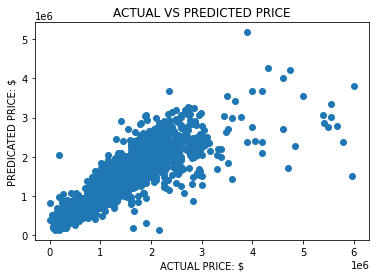

In [13]:
predictions = model.predict(X_test)

#
for i in range(50):
    diff = (predictions[i][0] - test['Price'].iloc[i])/1000
    print('PREDICTION: ${0}'.format(predictions[i][0]) + '   ACTUAL: '+format(test['Price'].iloc[i]) + f' DIFFERENCE: ${diff}')



plt.scatter(Y_test.iloc[0:2000],predictions[0:2000])
plt.title("ACTUAL VS PREDICTED PRICE")
plt.xlabel("ACTUAL PRICE: $")
plt.ylabel("PREDICATED PRICE: $")

<h5> SAVE MODEL </h5>

In [6]:
model.save("models/1")

NameError: name 'model' is not defined

<h4> SERVE MODEL</h4>
<h5> RUN TF SERVING DOCKER CONTAINER </h5>

In [5]:
#docker run -it -v /home/khaled/AUTOMATION-EXCEL\:/tf_serving -p 8601:8601 --entrypoint /bin/bash tensorflow/serving
#tensorflow_model_server --rest_api_port=8601 --model_name=melb_price --model_base_path=/tf_serving/saved_models/

client = docker.from_env()
container = client.containers.run(image = "tensorflow/serving", ports = {8601:8601},volumes = ['/home/khaled/ML/Real-Estate-Price-Estimate:/tf_serving'], detach=True)
container.exec_run('/bin/bash')
print(container.exec_run('ls'))
container.exec_run('tensorflow_model_server --rest_api_port=8601 --model_name=real_estate_price_est --model_base_path=/tf_serving/models/',detach = True)

ExecResult(exit_code=0, output=b'bin\nboot\ndev\netc\nhome\nlib\nlib64\nmedia\nmnt\nmodels\nopt\nproc\nroot\nrun\nsbin\nsrv\nsys\ntf_serving\ntmp\nusr\nvar\n')


ExecResult(exit_code=None, output='')

In [ ]:
input = X_test.to_numpy().tolist()[0:1]

data = {"instances": input}
test.head(10)

<h4> API CALL FOR PREDICTION</h4>
<h5>  REST API POST</h5>

In [ ]:
#%%bash
#curl -d '{"instances": [[0.25,0.07553956834532373,0.0,0.25,0.0,0.1937046004842615,0.9103448275862069,0.516068393160683,0.4633053471477789,1.0]]}' \
#-X POST http://localhost:8601/v1/models/melb_price:predict

r = requests.post(url="http://localhost:8601/v1/models/real_estate_price_est:predict", data=json.dumps(data))
print(r.json())